In [1]:
%matplotlib notebook

import math
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D  
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from simulation_view import SimulationView

In [2]:
def get_simulation_view():
#     return SimulationView(np.array([random.random(), random.random(), random.random()]) * 10000 + 5000, [0, 0])
    return SimulationView([6000, 7000, 12000], [0, 0])


class Environment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, **kwargs):
        super(Environment, self).__init__()
        self.reward_range = (-math.inf, -math.inf)
        self.action_space = gym.spaces.Box(np.array([0]), np.array([1]), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=1e5, shape=(3,))
        self.simulation_view = get_simulation_view()
        self.simulation_step = 0
        self.plot_x = np.array([])
        self.plot_y = np.array([])
        self.draw_plot = kwargs.get('draw_plot')
        self.draw_plot_freq = kwargs.get('draw_plot_freq')

    def step(self, action): 
        self.last_action = action
        old_obs = list(self.simulation_view.simulation.entityCount)
        self.simulation_view.step([action[0] * 1e5, 0])
        obs = np.array(self.simulation_view.simulation.entityCount)
        self.plot_x = np.append(self.plot_x, obs[0])
        self.plot_y = np.append(self.plot_y, obs[1])
        # reward = 1e5 - np.abs(self.simulation_view.simulation.entityCount[0] - self.simulation_view.simulation.entityCount[1])
        # reward = self.simulation_step
        # reward = 1
        reward = 100 / (100 + np.sum(np.abs(obs - old_obs)))
        # reward = 1 - min(abs(1 - np.average(np.array(obs) / np.array(old_obs))), 1)
        # reward = 2000 - np.sum(np.abs(obs - old_obs))
        # reward = 1 if action[0] > 0.4 and action[0] < 0.6 else 0
        # reward = -1 if np.any(np.array(self.simulation_view.simulation.entityCount) < 100) else 1
        # reward = 10000.0 - abs(5000 - obs[0]) - abs(5000 - obs[1])
        # reward = (30000.0 - obs[0] - obs[1]) / 30000.0
        done = bool(np.any(np.array(self.simulation_view.simulation.entityCount) < 1000)) \
               or bool(self.simulation_step > 300)
               # or bool(np.sum(np.abs(obs - old_obs)) > (1000 - self.simulation_step) * 2)
              
        self.simulation_step += 1

        return obs, reward, done, {}

    def reset(self):
        self.simulation_view = get_simulation_view()
        self.simulation_step = 0
        self.plot_x = np.array([])
        self.plot_y = np.array([])
        return np.array(self.simulation_view.simulation.entityCount)

    def render(self, mode='human', close=False):
        if self.simulation_step != 0 and self.simulation_step % self.draw_plot_freq == 0:
            self.draw_plot(self.plot_x, self.plot_y)
        
        
check_env(Environment())

/home/piotr/Projects/anfis_game_of_life/venv/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/piotr/Projects/anfis_game_of_life/venv/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:231: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [3]:
def get_empty_model():
    env = Environment()
    return PPO('MlpPolicy', env, clip_range=0.1, verbose=1, tensorboard_log="./logs/")


def learn_model(steps=100000, **kwargs):
    def draw_plot(x, y):
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
        fig.canvas.draw()

    eval_callback=None
    if kwargs.get('evaluate'):
        fig, ax = plt.subplots(1,1)
        ax.plot([0, 20000], [0, 20000])
        eval_callback = EvalCallback(Environment(draw_plot=draw_plot, draw_plot_freq=10), best_model_save_path='./logs/',
                                     log_path='./logs/', eval_freq=kwargs.get('eval_freq', 10000), render=True)
    
    model = get_empty_model()
    model.learn(total_timesteps=steps, callback=eval_callback)
    return model


def evaluate_model(model, **kwargs):
    def draw_plot(x, y):
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
        fig.canvas.draw()
    fig, ax = plt.subplots(1,1)
    ax.plot([0, 20000], [0, 20000])
    
    env = Environment(draw_plot=draw_plot, draw_plot_freq=kwargs.get('draw_plot_freq', 10))
    evaluate_policy(model, env, render=True)
    

def draw_model_surface(model):
    def fun(x, y):
        return list(map(lambda x: model.predict([x[0], x[1]], deterministic=True)[0][0], zip(x, y)))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(5000, 10000, 100)
    X, Y = np.meshgrid(x, y)
    zs = np.array(fun(np.ravel(X), np.ravel(Y)))
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)
    plt.show()

<IPython.core.display.Javascript object>


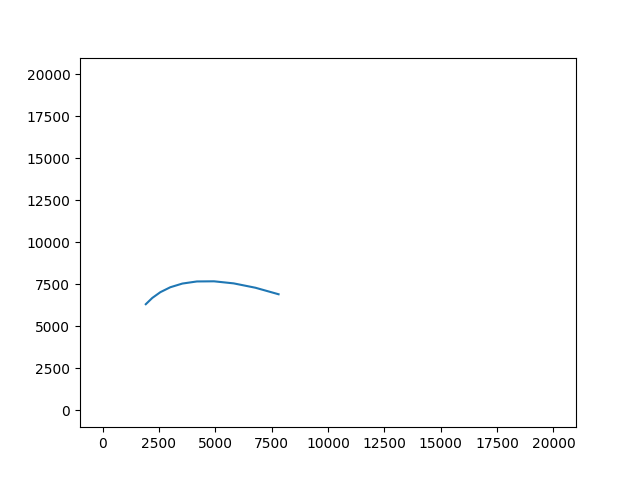

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/PPO_11
Eval num_timesteps=1000, episode_reward=0.43 +/- 0.14
Episode length: 8.60 +/- 1.74
New best mean reward!
Eval num_timesteps=2000, episode_reward=0.29 +/- 0.11
Episode length: 7.80 +/- 1.83
---------------------------------
| eval/              |          |
|    mean_ep_length  | 7.8      |
|    mean_reward     | 0.294    |
| time/              |          |
|    fps             | 846      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=3000, episode_reward=0.60 +/- 0.23
Episode length: 10.60 +/- 2.06
New best mean reward!
Eval num_timesteps=4000, episode_reward=0.60 +/- 0.14
Episode length: 11.00 +/- 1.41
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 11          |
|    mean_reward          | 0.604       |
| time/    

KeyboardInterrupt: 

In [11]:
model = learn_model(1000000, evaluate=True, eval_freq=1000)

In [7]:
model = PPO.load("logs/best_model.zip")

<IPython.core.display.Javascript object>


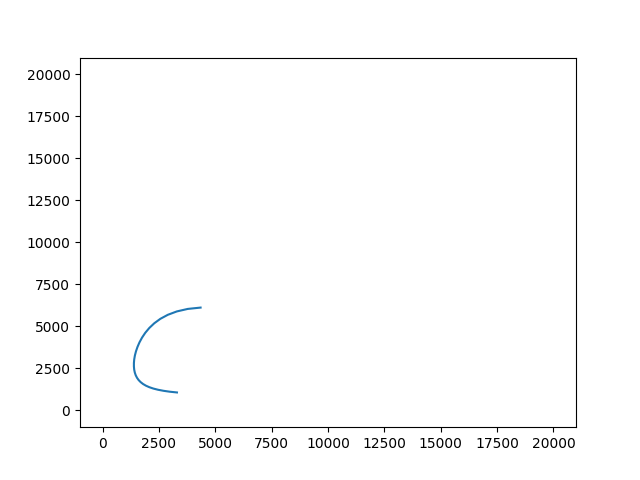

In [10]:
evaluate_model(model)

In [ ]:
draw_model_surface(model)